# Automating Data Inputs

In [1]:
from local_module import load_temp_profile

data = load_temp_profile()
data

AiiDAProfile(profile=Profile<uuid='cf39c297ec834397a1d082c7d3ccd51e' name='temp_profile'>, computer=<Computer: local_direct (localhost), pk: 1>, pw_code=<Code: Remote code 'pw.x' on local_direct, pk: 1, uuid: 38f40805-09e6-434e-8e5d-95f08710401a>, pseudos=SsspFamily<1>)

In [2]:
%verdi status --no-rmq

 ✔ version:     AiiDA v2.0.1
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida
 ✔ profile:     temp_profile
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida/repository/temp_profile
 ⏺ daemon:      The daemon is not running


```console
$ aiida-pseudo install sssp -x PBE -p efficiency -v 1.1
```

In [ ]:
# import json
# from pathlib import Path

# from aiida import orm

# from aiida_pseudo.cli.install import download_sssp
# from aiida_pseudo.cli.utils import create_family_from_archive
# from aiida_pseudo.groups.family import SsspConfiguration, SsspFamily

# config = SsspConfiguration("1.1", "PBE", "efficiency")
# label = SsspFamily.format_configuration_label(config)

# try:
#     family = orm.Group.collection.get(label=label)
# except:
#     pseudos = Path("sssp_pseudos")
#     pseudos.mkdir(exist_ok=True)

#     download_sssp(config, pseudos / "sssp.tar.gz", pseudos / "sssp.json")

#     family = create_family_from_archive(
#         SsspFamily,
#         label,
#         pseudos / "sssp.tar.gz",
#     )
#     family.set_cutoffs(
#         {
#             k: {i: v[i] for i in ["cutoff_wfc", "cutoff_rho"]}
#             for k, v in json.loads((pseudos / "sssp.json").read_text()).items()
#         },
#         "normal",
#         unit="Ry",
#     )

# str(family)

TODO pymatgen / ase integration

In [3]:


# entry = CodEntry("http://www.crystallography.net/cod/1526655.cif")
# structure = entry.get_aiida_structure()
# structure.get_pymatgen()

Structure Summary
Lattice
    abc : 5.381 5.381 5.381
 angles : 90.0 90.0 90.0
 volume : 155.80772134100002
      A : 5.381 0.0 3.294912213105954e-16
      B : -3.294912213105954e-16 5.381 3.294912213105954e-16
      C : 0.0 0.0 5.381
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Si (1.3453, 1.3453, 1.3453) [0.2500, 0.2500, 0.2500]
PeriodicSite: Si (-0.0000, 2.6905, 2.6905) [0.0000, 0.5000, 0.5000]
PeriodicSite: Si (4.0358, 1.3453, 4.0357) [0.7500, 0.2500, 0.7500]
PeriodicSite: Si (2.6905, 0.0000, 2.6905) [0.5000, 0.0000, 0.5000]
PeriodicSite: Si (1.3452, 4.0358, 4.0357) [0.2500, 0.7500, 0.7500]
PeriodicSite: Si (2.6905, 2.6905, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Si (4.0358, 4.0358, 1.3453) [0.7500, 0.7500, 0.2500]

In [3]:
from aiida import orm, engine
from aiida.tools.dbimporters.plugins.cod import CodEntry
from aiida.tools.visualization import Graph


from aiida_quantumespresso.calculations.pw import PwCalculation


class MyWorkChain(engine.WorkChain):
    @classmethod
    def define(cls, spec: engine.ProcessSpec):
        """Specify inputs, outputs, and the workchain outline."""
        super().define(spec)

        spec.input("cod_id", valid_type=orm.Int)
        spec.input("pseudo_family", valid_type=orm.Str)
        spec.input("nkpoints", valid_type=orm.Int)
        spec.expose_inputs(
            PwCalculation, "pw", exclude=("structure", "pseudos", "kpoints")
        )
        spec.outline(cls.run_pw, cls.result)
        spec.expose_outputs(PwCalculation)

    def run_pw(self):
        """Pass the input as an output."""
        family = orm.Group.collection.get(label=self.inputs.pseudo_family.value)
        entry = CodEntry(
            f"http://www.crystallography.net/cod/{self.inputs.cod_id.value}.cif"
        )
        structure = entry.get_aiida_structure()
        pseudos = family.get_pseudos(structure=structure)
        kpoints = orm.KpointsData()
        kpoints.set_cell_from_structure(structure)
        kpoints.set_kpoints_mesh(
            [self.inputs.nkpoints.value] * 3,
        )
        inputs = self.exposed_inputs(PwCalculation, "pw")
        future = self.submit(
            PwCalculation,
            structure=structure,
            pseudos=pseudos,
            kpoints=kpoints,
            **inputs,
        )
        return self.to_context(pw=future)

    def result(self):
        """Pass the result as an output."""
        self.out_many(self.exposed_outputs(self.ctx.pw, PwCalculation))

In [4]:
builder = MyWorkChain.get_builder()
builder.cod_id = orm.Int(1526655)
builder.pseudo_family = orm.Str("SSSP/1.1/PBE/efficiency")
builder.pw.code = orm.load_code("pw.x@local_direct")
builder.nkpoints = orm.Int(4)
builder.pw.parameters = orm.Dict(
    dict={
        "SYSTEM": {
            "nosym": False,
            "degauss": 0.01,
            "ecutrho": 240.0,
            "ecutwfc": 30.0,
            "smearing": "cold",
            "occupations": "smearing",
        },
        "CONTROL": {
            "tprnfor": True,
            "tstress": True,
            "calculation": "relax",
            "max_seconds": 41040.0,
            "etot_conv_thr": 0.0002,
            "forc_conv_thr": 0.001,
        },
        "ELECTRONS": {
            "conv_thr": 8e-10, 
            "mixing_beta": 0.4, 
            "electron_maxstep": 80
        },
    }
)

output = engine.run_get_node(builder)

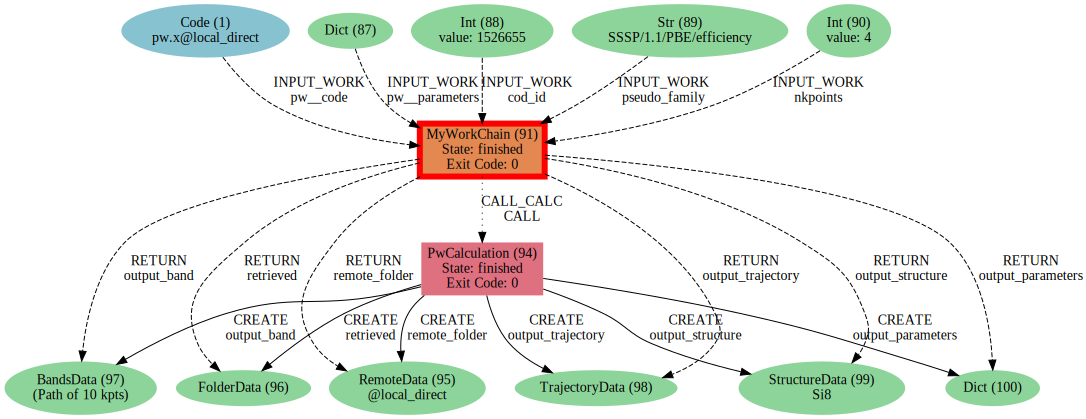

In [5]:
graph = Graph()
graph.recurse_ancestors(output.node, annotate_links="both")
graph.recurse_descendants(output.node, annotate_links="both")
graph.graphviz